<a href="https://colab.research.google.com/github/bhuvan3535-boop/NeuroPlay-A-Deep-Learning-Model-for-Subject-Independent-Emotion-Classification-from-EEG/blob/main/Emotion_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Install the MNE library (it's not pre-installed on Colab)
!pip install mne

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 98.7 MB/s eta 0:00:00


In [11]:
!ls /content/drive/MyDrive/

'12th tc.jpg'
'1st sem result_merged.pdf'
 20180406_134222.jpg
 20180406_134227.jpg
 2018-08-27-21-33-24-890.jpg
 20190929_082857.jpg
 20190929_082900.jpg
 20190929_082928.jpg
 20190929_083025.jpg
 20190929_083033.jpg
 20190929_083055.jpg
 20190929_084145.jpg
 20190929_095548.jpg
 20200216_080218.jpg
 20200216_083256.jpg
 20200525_135525.jpg
 20200612_112019.jpg
 20200612_205837.jpg
 20200612_210041.jpg
 20200612_210050.jpg
 20200612_210056.jpg
 20200612_210100.jpg
 20200612_210118.jpg
 20200612_210126.jpg
 20200612_210137.jpg
'20200612_210147(0).jpg'
 20200612_210150.jpg
'20200612_210209(0).jpg'
 20200612_210211.jpg
 20200612_210252.jpg
 20200612_210304.jpg
 20200617_091009.jpg
 2223P1240100039.pdf
 aadhaar_dataset.xlsx
'Aadhar (1).pdf'
'Aadhar (2).pdf'
 Aadhar.pdf
'adhaar 200kb.jpg'
 adhaar.jpg
 batch5_report.pdf
'BE results_merged (1).pdf'
'BE results_merged.pdf'
 BhuvanRNayak_DSATM.pdf
'BhuvanRNayak_resume (10).pdf'
'BhuvanRNayak_Resume (1) (10).pdf'
'BhuvanRNayak_Resume (1) (11).p

In [12]:
import pandas as pd
import numpy as np
import mne
import glob
import os
import re

# --- 1. DEFINE CONSTANTS ---
SAMPLING_RATE = 128
CHANNEL_NAMES = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
LABEL_MAP = { 'G1': 0, 'G2': 1, 'G3': 2, 'G4': 3 }
LABEL_NAMES = {0: 'Boring', 1: 'Calm', 2: 'Horror', 3: 'Funny'}

EPOCH_DURATION_SEC = 3
N_SAMPLES_PER_EPOCH = int(EPOCH_DURATION_SEC * SAMPLING_RATE) # This will be 384

# --- Lists to hold all data from ALL subjects ---
all_epochs_list = []
all_labels_list = []
all_groups_list = []

# --- 2. FIND ALL SUBJECT FOLDERS (Robust Method) ---
# This is the path to your GAMEEMO folder
base_data_path = r'/content/drive/MyDrive/GAMEEMO (1)'

subject_folders = []

# Use os.listdir() to avoid issues with special characters in 'glob'
try:
    all_items_in_dir = os.listdir(base_data_path)
except FileNotFoundError:
    print(f"ERROR: The path {base_data_path} was not found.")
    print("Please double-check your base_data_path variable.")
    all_items_in_dir = []

for item_name in all_items_in_dir:
    # Check if it's a folder, starts with '(', and ends with ')'
    full_path = os.path.join(base_data_path, item_name)
    if (os.path.isdir(full_path) and
        item_name.startswith('(') and
        item_name.endswith(')')):

        subject_folders.append(full_path)

subject_folders.sort() # Sorts them (S01), (S02), ...

print(f"Found {len(subject_folders)} subjects.")
print(f"Each epoch will have {N_SAMPLES_PER_EPOCH} timesteps.")

# --- 3. OUTER LOOP: Iterate through each subject ---
for subject_folder_path in subject_folders:

    # --- This is the new, safer way to get the ID ---
    folder_name = os.path.basename(subject_folder_path) # Gets '(S01)'
    subject_id = folder_name.strip('()')                # Gets 'S01'
    # --- End new part ---

    subject_group_id = int(subject_id[1:])

    print(f"\n--- Processing Subject: {subject_id} ---")

    data_folder_path = os.path.join(subject_folder_path, 'Preprocessed EEG Data', '.csv format')
    file_search_pattern = os.path.join(data_folder_path, f'{subject_id}G*AllChannels.csv')
    subject_files = glob.glob(file_search_pattern)
    subject_files.sort()

    if not subject_files:
        print(f"Warning: No files found for {subject_id} at {data_folder_path}")
        continue

    # --- 4. INNER LOOP: Process each game file (G1-G4) for this subject ---
    for csv_file_path in subject_files:
        file_name = os.path.basename(csv_file_path)
        game_key = file_name.split('AllChannels.csv')[0][3:]

        if game_key not in LABEL_MAP:
            continue

        label = LABEL_MAP[game_key]

        # 1. Load Data
        eeg_df = pd.read_csv(csv_file_path)
        eeg_df = eeg_df[CHANNEL_NAMES]

        # 2. Convert to MNE
        if eeg_df['AF3'].mean() < 0.1:
             eeg_data_numpy = eeg_df.values.T * 1e6
        else:
             eeg_data_numpy = eeg_df.values.T

        # 3. Create MNE Object
        ch_types = ['eeg'] * len(CHANNEL_NAMES)
        info = mne.create_info(ch_names=CHANNEL_NAMES, sfreq=SAMPLING_RATE, ch_types=ch_types)
        info.set_montage('standard_1020')
        raw = mne.io.RawArray(eeg_data_numpy, info, verbose=False)

        # 4. Epoching
        epochs = mne.make_fixed_length_epochs(raw, duration=EPOCH_DURATION_SEC, overlap=1.0, preload=True, verbose=False)

        # 5. GET EPOCH DATA
        epoch_data = epochs.get_data() # (n_epochs, n_channels, n_samples)
        n_epochs = epoch_data.shape[0]

        # 6. Append to our MASTER lists
        all_epochs_list.append(epoch_data)
        all_labels_list.extend([label] * n_epochs)
        all_groups_list.extend([subject_group_id] * n_epochs)

# --- 6. FINAL STEP: Combine all data ---
if not all_epochs_list:
    print("\n--- No data was processed. Check your paths and folder structure. ---")
else:
    X = np.concatenate(all_epochs_list)
    y = np.array(all_labels_list)
    groups = np.array(all_groups_list)

    # 7. CRITICAL: Reshape data for the 1D-CNN
    X = np.transpose(X, (0, 2, 1)) # -> Shape (samples, timesteps, channels)

    print(f"\n--- ALL PROCESSING COMPLETE ---")
    print(f"Feature matrix 'X' shape: {X.shape}")
    print(f"Label vector 'y' shape: {y.shape}")
    print(f"Groups vector 'groups' shape: {groups.shape}")
    print(f"Total subjects processed: {len(np.unique(groups))}")

Found 28 subjects.
Each epoch will have 384 timesteps.

--- Processing Subject: S01 ---

--- Processing Subject: S02 ---

--- Processing Subject: S03 ---

--- Processing Subject: S04 ---

--- Processing Subject: S05 ---

--- Processing Subject: S06 ---

--- Processing Subject: S07 ---

--- Processing Subject: S08 ---

--- Processing Subject: S09 ---

--- Processing Subject: S10 ---

--- Processing Subject: S11 ---

--- Processing Subject: S12 ---

--- Processing Subject: S13 ---

--- Processing Subject: S14 ---

--- Processing Subject: S15 ---

--- Processing Subject: S16 ---

--- Processing Subject: S17 ---

--- Processing Subject: S18 ---

--- Processing Subject: S19 ---

--- Processing Subject: S20 ---

--- Processing Subject: S21 ---

--- Processing Subject: S22 ---

--- Processing Subject: S23 ---

--- Processing Subject: S24 ---

--- Processing Subject: S25 ---

--- Processing Subject: S26 ---

--- Processing Subject: S27 ---

--- Processing Subject: S28 ---

--- ALL PROCESSING C


--- FOLD 1/28 | TESTING on Subject 1 ---
Data normalized. Train shape: (15984, 384, 14), Test shape: (592, 384, 14)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.3245 - loss: 1.6541 - val_accuracy: 0.3621 - val_loss: 1.3350
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4954 - loss: 1.0890 - val_accuracy: 0.3740 - val_loss: 1.3019
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6042 - loss: 0.8793 - val_accuracy: 0.4121 - val_loss: 1.2680
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6677 - loss: 0.7723 - val_accuracy: 0.4916 - val_loss: 1.1335
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7212 - loss: 0.6619 - val_accuracy: 0.5610 - val_loss: 1.0330
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7607 - loss: 0.5791 - val_accuracy: 0.5622 - val_loss: 1.0682
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7925 - loss: 0.5023 - val_accuracy: 0.6235 - val_loss: 0.8936
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8164 - loss: 0.4471 - val_accuracy: 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.3154 - loss: 1.6350 - val_accuracy: 0.3421 - val_loss: 1.3529
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4889 - loss: 1.1092 - val_accuracy: 0.3796 - val_loss: 1.3219
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6024 - loss: 0.9148 - val_accuracy: 0.4290 - val_loss: 1.2504
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6762 - loss: 0.7619 - val_accuracy: 0.4853 - val_loss: 1.1363
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7234 - loss: 0.6692 - val_accuracy: 0.5816 - val_loss: 1.0167
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7679 - loss: 0.5717 - val_accuracy: 0.5860 - val_loss: 0.9581
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7944 - loss: 0.5072 - val_accuracy: 0.6398 - val_loss: 0.8712
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8214 - loss: 0.4475 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3130 - loss: 1.7128 - val_accuracy: 0.3627 - val_loss: 1.3723
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4806 - loss: 1.1277 - val_accuracy: 0.3909 - val_loss: 1.2624
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5936 - loss: 0.9257 - val_accuracy: 0.4165 - val_loss: 1.2840
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6466 - loss: 0.8139 - val_accuracy: 0.4959 - val_loss: 1.1708
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7089 - loss: 0.6965 - val_accuracy: 0.5291 - val_loss: 1.1169
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7536 - loss: 0.5968 - val_accuracy: 0.5872 - val_loss: 0.9513
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7920 - loss: 0.5103 - val_accuracy: 0.5804 - val_loss: 1.0868
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8134 - loss: 0.4640 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.3067 - loss: 1.7177 - val_accuracy: 0.3233 - val_loss: 1.3818
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4821 - loss: 1.1332 - val_accuracy: 0.4040 - val_loss: 1.2700
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6020 - loss: 0.9105 - val_accuracy: 0.4459 - val_loss: 1.2311
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6799 - loss: 0.7693 - val_accuracy: 0.5059 - val_loss: 1.0949
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7312 - loss: 0.6508 - val_accuracy: 0.5622 - val_loss: 1.0412
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7685 - loss: 0.5697 - val_accuracy: 0.5629 - val_loss: 1.0560
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7948 - loss: 0.5195 - val_accuracy: 0.6048 - val_loss: 0.9770
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8277 - loss: 0.4361 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3130 - loss: 1.6009 - val_accuracy: 0.3271 - val_loss: 1.3230
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4890 - loss: 1.1130 - val_accuracy: 0.4228 - val_loss: 1.2897
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6037 - loss: 0.8990 - val_accuracy: 0.4428 - val_loss: 1.2310
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6776 - loss: 0.7640 - val_accuracy: 0.5128 - val_loss: 1.0965
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7263 - loss: 0.6531 - val_accuracy: 0.5729 - val_loss: 1.0393
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7680 - loss: 0.5572 - val_accuracy: 0.6029 - val_loss: 0.9310
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7912 - loss: 0.5144 - val_accuracy: 0.6535 - val_loss: 0.8497
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8296 - loss: 0.4296 - val_accuracy: 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.3249 - loss: 1.6938 - val_accuracy: 0.3390 - val_loss: 1.3646
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4975 - loss: 1.0756 - val_accuracy: 0.3884 - val_loss: 1.3345
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5788 - loss: 0.9131 - val_accuracy: 0.3884 - val_loss: 1.2770
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6426 - loss: 0.8151 - val_accuracy: 0.4728 - val_loss: 1.1872
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7020 - loss: 0.7005 - val_accuracy: 0.5122 - val_loss: 1.1080
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7395 - loss: 0.6126 - val_accuracy: 0.5453 - val_loss: 1.0494
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7715 - loss: 0.5384 - val_accuracy: 0.6210 - val_loss: 0.8763
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7984 - loss: 0.4763 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.3344 - loss: 1.6832 - val_accuracy: 0.3646 - val_loss: 1.3274
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5148 - loss: 1.0518 - val_accuracy: 0.3990 - val_loss: 1.2717
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6023 - loss: 0.8853 - val_accuracy: 0.4371 - val_loss: 1.1958
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6661 - loss: 0.7720 - val_accuracy: 0.4984 - val_loss: 1.1366
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7188 - loss: 0.6612 - val_accuracy: 0.5435 - val_loss: 1.0459
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7668 - loss: 0.5559 - val_accuracy: 0.6010 - val_loss: 0.9237
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7907 - loss: 0.5063 - val_accuracy: 0.6448 - val_loss: 0.8633
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8113 - loss: 0.4657 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3390 - loss: 1.6690 - val_accuracy: 0.3640 - val_loss: 1.3013
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5279 - loss: 1.0548 - val_accuracy: 0.3709 - val_loss: 1.3158
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6182 - loss: 0.8738 - val_accuracy: 0.4384 - val_loss: 1.2254
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6940 - loss: 0.7332 - val_accuracy: 0.4834 - val_loss: 1.1519
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7437 - loss: 0.6189 - val_accuracy: 0.5272 - val_loss: 1.0706
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7793 - loss: 0.5356 - val_accuracy: 0.5622 - val_loss: 1.0182
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7991 - loss: 0.4840 - val_accuracy: 0.6010 - val_loss: 0.9613
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8169 - loss: 0.4529 - val_accuracy: 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.3307 - loss: 1.6331 - val_accuracy: 0.3465 - val_loss: 1.3416
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5410 - loss: 1.0231 - val_accuracy: 0.4253 - val_loss: 1.2553
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6304 - loss: 0.8424 - val_accuracy: 0.4009 - val_loss: 1.2421
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6935 - loss: 0.7374 - val_accuracy: 0.4534 - val_loss: 1.2105
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7431 - loss: 0.6056 - val_accuracy: 0.5297 - val_loss: 1.0803
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7796 - loss: 0.5452 - val_accuracy: 0.6066 - val_loss: 0.9400
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8012 - loss: 0.4767 - val_accuracy: 0.6166 - val_loss: 0.9196
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8268 - loss: 0.4335 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.3122 - loss: 1.7509 - val_accuracy: 0.3533 - val_loss: 1.3292
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5195 - loss: 1.0745 - val_accuracy: 0.3684 - val_loss: 1.3314
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6297 - loss: 0.8485 - val_accuracy: 0.4472 - val_loss: 1.2159
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6975 - loss: 0.7145 - val_accuracy: 0.4816 - val_loss: 1.1548
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7520 - loss: 0.6114 - val_accuracy: 0.5378 - val_loss: 1.0299
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7794 - loss: 0.5360 - val_accuracy: 0.5979 - val_loss: 0.9547
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8198 - loss: 0.4572 - val_accuracy: 0.6498 - val_loss: 0.8440
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8339 - loss: 0.4036 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3318 - loss: 1.6298 - val_accuracy: 0.3258 - val_loss: 1.3409
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5351 - loss: 1.0291 - val_accuracy: 0.4109 - val_loss: 1.2883
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6261 - loss: 0.8553 - val_accuracy: 0.4396 - val_loss: 1.2154
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6911 - loss: 0.7288 - val_accuracy: 0.5247 - val_loss: 1.0880
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7451 - loss: 0.6176 - val_accuracy: 0.5285 - val_loss: 1.1156
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7755 - loss: 0.5517 - val_accuracy: 0.6191 - val_loss: 0.9465
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8006 - loss: 0.4907 - val_accuracy: 0.6504 - val_loss: 0.8791
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8327 - loss: 0.4218 - val_accuracy: 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.3255 - loss: 1.6795 - val_accuracy: 0.3139 - val_loss: 1.4012
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5233 - loss: 1.0448 - val_accuracy: 0.3402 - val_loss: 1.4287
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6223 - loss: 0.8496 - val_accuracy: 0.3752 - val_loss: 1.4003
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6863 - loss: 0.7382 - val_accuracy: 0.4115 - val_loss: 1.4350
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7283 - loss: 0.6402 - val_accuracy: 0.4909 - val_loss: 1.2587
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7776 - loss: 0.5299 - val_accuracy: 0.5266 - val_loss: 1.3259
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8108 - loss: 0.4599 - val_accuracy: 0.5366 - val_loss: 1.3630
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8327 - loss: 0.4110 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3167 - loss: 1.6545 - val_accuracy: 0.3021 - val_loss: 1.4053
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5283 - loss: 1.0355 - val_accuracy: 0.3058 - val_loss: 1.4535
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6422 - loss: 0.8436 - val_accuracy: 0.3827 - val_loss: 1.3704
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7076 - loss: 0.6955 - val_accuracy: 0.4121 - val_loss: 1.3835
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7721 - loss: 0.5543 - val_accuracy: 0.4434 - val_loss: 1.4499
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8030 - loss: 0.4911 - val_accuracy: 0.4484 - val_loss: 1.5162
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8372 - loss: 0.4228 - val_accuracy: 0.5066 - val_loss: 1.4776
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8508 - loss: 0.3808 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.3146 - loss: 1.6865 - val_accuracy: 0.3102 - val_loss: 1.3881
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5038 - loss: 1.0733 - val_accuracy: 0.3652 - val_loss: 1.3378
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6210 - loss: 0.8691 - val_accuracy: 0.3984 - val_loss: 1.3922
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6772 - loss: 0.7562 - val_accuracy: 0.3977 - val_loss: 1.4137
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7461 - loss: 0.6227 - val_accuracy: 0.4765 - val_loss: 1.3768
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7912 - loss: 0.5153 - val_accuracy: 0.4759 - val_loss: 1.3034
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8246 - loss: 0.4459 - val_accuracy: 0.5397 - val_loss: 1.4953
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8469 - loss: 0.3945 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.3209 - loss: 1.7361 - val_accuracy: 0.3458 - val_loss: 1.3536
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4863 - loss: 1.1062 - val_accuracy: 0.3665 - val_loss: 1.3134
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6035 - loss: 0.9126 - val_accuracy: 0.4346 - val_loss: 1.2314
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6779 - loss: 0.7622 - val_accuracy: 0.4809 - val_loss: 1.1385
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7301 - loss: 0.6506 - val_accuracy: 0.5541 - val_loss: 1.0166
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7728 - loss: 0.5582 - val_accuracy: 0.5647 - val_loss: 1.0168
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7999 - loss: 0.4952 - val_accuracy: 0.6035 - val_loss: 0.9391
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8349 - loss: 0.4155 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3026 - loss: 1.6888 - val_accuracy: 0.3371 - val_loss: 1.3463
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4710 - loss: 1.1409 - val_accuracy: 0.3502 - val_loss: 1.3400
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5901 - loss: 0.9309 - val_accuracy: 0.4059 - val_loss: 1.2706
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6675 - loss: 0.7758 - val_accuracy: 0.4897 - val_loss: 1.1231
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7324 - loss: 0.6475 - val_accuracy: 0.5591 - val_loss: 1.0518
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7842 - loss: 0.5383 - val_accuracy: 0.5954 - val_loss: 0.9734
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8117 - loss: 0.4720 - val_accuracy: 0.6229 - val_loss: 0.9063
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8372 - loss: 0.4167 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3087 - loss: 1.6455 - val_accuracy: 0.3659 - val_loss: 1.3255
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4921 - loss: 1.1169 - val_accuracy: 0.3846 - val_loss: 1.2953
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6068 - loss: 0.9075 - val_accuracy: 0.4753 - val_loss: 1.1403
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6773 - loss: 0.7703 - val_accuracy: 0.4909 - val_loss: 1.1562
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7292 - loss: 0.6577 - val_accuracy: 0.5879 - val_loss: 0.9678
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7718 - loss: 0.5680 - val_accuracy: 0.5716 - val_loss: 0.9940
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7983 - loss: 0.5061 - val_accuracy: 0.6610 - val_loss: 0.8121
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8301 - loss: 0.4210 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3291 - loss: 1.6380 - val_accuracy: 0.3602 - val_loss: 1.3076
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5009 - loss: 1.0879 - val_accuracy: 0.3865 - val_loss: 1.2800
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6118 - loss: 0.8838 - val_accuracy: 0.4534 - val_loss: 1.2039
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6897 - loss: 0.7365 - val_accuracy: 0.5022 - val_loss: 1.0732
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7420 - loss: 0.6260 - val_accuracy: 0.5772 - val_loss: 1.0103
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7826 - loss: 0.5287 - val_accuracy: 0.6085 - val_loss: 0.9905
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8078 - loss: 0.4828 - val_accuracy: 0.6954 - val_loss: 0.7830
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8462 - loss: 0.4027 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3200 - loss: 1.6428 - val_accuracy: 0.3515 - val_loss: 1.3005
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5098 - loss: 1.0677 - val_accuracy: 0.3877 - val_loss: 1.2595
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5928 - loss: 0.8787 - val_accuracy: 0.4365 - val_loss: 1.1895
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6714 - loss: 0.7532 - val_accuracy: 0.4853 - val_loss: 1.2288
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7258 - loss: 0.6422 - val_accuracy: 0.5604 - val_loss: 1.0136
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7721 - loss: 0.5522 - val_accuracy: 0.5947 - val_loss: 0.9589
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8067 - loss: 0.4871 - val_accuracy: 0.6498 - val_loss: 0.8421
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8301 - loss: 0.4277 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.3005 - loss: 1.7377 - val_accuracy: 0.3502 - val_loss: 1.3283
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4430 - loss: 1.1870 - val_accuracy: 0.3609 - val_loss: 1.3004
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5751 - loss: 0.9496 - val_accuracy: 0.4415 - val_loss: 1.2247
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6493 - loss: 0.7970 - val_accuracy: 0.4440 - val_loss: 1.2598
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6976 - loss: 0.7169 - val_accuracy: 0.4909 - val_loss: 1.1421
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7369 - loss: 0.6250 - val_accuracy: 0.5410 - val_loss: 1.0847
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7750 - loss: 0.5475 - val_accuracy: 0.6154 - val_loss: 0.9241
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8149 - loss: 0.4563 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.3321 - loss: 1.5913 - val_accuracy: 0.3046 - val_loss: 1.3412
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5117 - loss: 1.0617 - val_accuracy: 0.4271 - val_loss: 1.2199
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6079 - loss: 0.8890 - val_accuracy: 0.4522 - val_loss: 1.1869
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6770 - loss: 0.7555 - val_accuracy: 0.5153 - val_loss: 1.0625
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7339 - loss: 0.6430 - val_accuracy: 0.5228 - val_loss: 1.1532
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7800 - loss: 0.5596 - val_accuracy: 0.5916 - val_loss: 1.0046
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8067 - loss: 0.4778 - val_accuracy: 0.6335 - val_loss: 0.9142
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8271 - loss: 0.4325 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.3205 - loss: 1.6634 - val_accuracy: 0.3427 - val_loss: 1.3196
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5063 - loss: 1.0776 - val_accuracy: 0.4021 - val_loss: 1.2463
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6054 - loss: 0.8988 - val_accuracy: 0.4490 - val_loss: 1.2138
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6764 - loss: 0.7560 - val_accuracy: 0.4778 - val_loss: 1.1555
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7246 - loss: 0.6555 - val_accuracy: 0.5466 - val_loss: 1.0323
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7717 - loss: 0.5593 - val_accuracy: 0.5841 - val_loss: 0.9574
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7907 - loss: 0.5101 - val_accuracy: 0.6110 - val_loss: 0.9486
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8187 - loss: 0.4611 - val_accuracy: 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.3430 - loss: 1.7487 - val_accuracy: 0.3427 - val_loss: 1.3353
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5063 - loss: 1.0563 - val_accuracy: 0.3740 - val_loss: 1.3261
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6103 - loss: 0.8880 - val_accuracy: 0.4422 - val_loss: 1.2653
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6789 - loss: 0.7566 - val_accuracy: 0.4740 - val_loss: 1.1985
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7206 - loss: 0.6720 - val_accuracy: 0.5572 - val_loss: 1.0557
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7682 - loss: 0.5508 - val_accuracy: 0.5747 - val_loss: 0.9861
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7926 - loss: 0.5096 - val_accuracy: 0.6141 - val_loss: 0.9394
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8110 - loss: 0.4539 - val_accuracy: 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.3166 - loss: 1.7393 - val_accuracy: 0.3440 - val_loss: 1.3542
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5040 - loss: 1.0812 - val_accuracy: 0.3696 - val_loss: 1.3257
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5967 - loss: 0.9010 - val_accuracy: 0.4053 - val_loss: 1.2603
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6695 - loss: 0.7492 - val_accuracy: 0.4271 - val_loss: 1.2108
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7085 - loss: 0.6827 - val_accuracy: 0.4916 - val_loss: 1.1334
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7439 - loss: 0.6025 - val_accuracy: 0.5453 - val_loss: 1.0637
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7825 - loss: 0.5170 - val_accuracy: 0.5854 - val_loss: 0.9782
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8022 - loss: 0.4762 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3124 - loss: 1.7655 - val_accuracy: 0.3333 - val_loss: 1.3745
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5184 - loss: 1.0612 - val_accuracy: 0.3652 - val_loss: 1.3374
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6064 - loss: 0.8809 - val_accuracy: 0.3702 - val_loss: 1.2899
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6679 - loss: 0.7682 - val_accuracy: 0.4065 - val_loss: 1.2640
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7209 - loss: 0.6695 - val_accuracy: 0.4847 - val_loss: 1.1771
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7672 - loss: 0.5793 - val_accuracy: 0.5253 - val_loss: 1.1221
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7946 - loss: 0.5089 - val_accuracy: 0.5679 - val_loss: 0.9974
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8148 - loss: 0.4614 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3139 - loss: 1.6691 - val_accuracy: 0.3240 - val_loss: 1.3384
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5125 - loss: 1.0880 - val_accuracy: 0.3909 - val_loss: 1.2939
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6023 - loss: 0.8996 - val_accuracy: 0.4353 - val_loss: 1.2258
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6861 - loss: 0.7418 - val_accuracy: 0.4628 - val_loss: 1.1663
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7186 - loss: 0.6553 - val_accuracy: 0.4790 - val_loss: 1.1841
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7714 - loss: 0.5540 - val_accuracy: 0.5666 - val_loss: 1.0104
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7957 - loss: 0.4934 - val_accuracy: 0.5791 - val_loss: 0.9483
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8163 - loss: 0.4576 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.3394 - loss: 1.6187 - val_accuracy: 0.3377 - val_loss: 1.3557
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5365 - loss: 1.0290 - val_accuracy: 0.3515 - val_loss: 1.3030
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6358 - loss: 0.8298 - val_accuracy: 0.4422 - val_loss: 1.2225
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6923 - loss: 0.7131 - val_accuracy: 0.4897 - val_loss: 1.1487
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7343 - loss: 0.6340 - val_accuracy: 0.5203 - val_loss: 1.0675
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7636 - loss: 0.5695 - val_accuracy: 0.5553 - val_loss: 1.0245
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7918 - loss: 0.5088 - val_accuracy: 0.6004 - val_loss: 0.9565
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8245 - loss: 0.4361 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3245 - loss: 1.6674 - val_accuracy: 0.3321 - val_loss: 1.3623
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5182 - loss: 1.0659 - val_accuracy: 0.3896 - val_loss: 1.2686
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6082 - loss: 0.8665 - val_accuracy: 0.4897 - val_loss: 1.1592
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6771 - loss: 0.7420 - val_accuracy: 0.5560 - val_loss: 1.0464
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7297 - loss: 0.6382 - val_accuracy: 0.5829 - val_loss: 1.0022
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7623 - loss: 0.5800 - val_accuracy: 0.6329 - val_loss: 0.8781
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7921 - loss: 0.5008 - val_accuracy: 0.6879 - val_loss: 0.8083
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8076 - loss: 0.4599 - val_accuracy: 

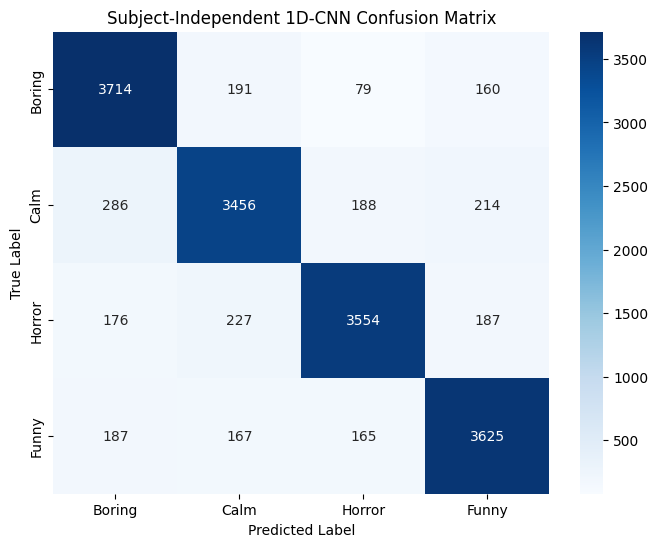

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import time

# --- 1. Define the 1D-CNN Model Architecture ---
# We create a function so we can build a fresh, new model for each fold
def build_1d_cnn_model(input_shape=(N_SAMPLES_PER_EPOCH, len(CHANNEL_NAMES))):
    model = Sequential()

    # Input shape: (384, 14)
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())

    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer: 4 classes, softmax for probabilities
    model.add(Dense(4, activation='softmax'))

    model.compile(
        loss='sparse_categorical_crossentropy', # Use this because our y is 0, 1, 2, 3
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

# --- 2. Set up the Cross-Validation Loop ---
logo = LeaveOneGroupOut()
n_splits = logo.get_n_splits(X, y, groups)

all_y_test = []
all_y_pred_classes = []
fold_accuracies = []

start_time = time.time()

# --- 3. Run the Cross-Validation Loop ---
for fold, (train_index, test_index) in enumerate(logo.split(X, y, groups)):

    test_subject_id = np.unique(groups[test_index])[0]
    print(f"\n--- FOLD {fold+1}/{n_splits} | TESTING on Subject {test_subject_id} ---")

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # --- 4. CRITICAL: Normalization ---
    # We must normalize the data. We fit the scaler ONLY on the training data
    # to prevent any data leakage from the test subject.
    # We must reshape 3D -> 2D to scale, then 2D -> 3D back.

    # Reshape (n_epochs, 384, 14) -> (n_epochs * 384, 14)
    scaler = StandardScaler()
    X_train_2d = X_train.reshape(-1, X_train.shape[-1])
    scaler.fit(X_train_2d)

    # Transform
    X_train_norm_2d = scaler.transform(X_train_2d)
    X_test_norm_2d = scaler.transform(X_test.reshape(-1, X_test.shape[-1]))

    # Reshape back to 3D
    X_train = X_train_norm_2d.reshape(X_train.shape)
    X_test = X_test_norm_2d.reshape(X_test.shape)

    print(f"Data normalized. Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    # 5. Build and Train the Model
    model = build_1d_cnn_model()

    # We'll use 10% of our *training* data as a validation set
    # to monitor for overfitting during training.
    history = model.fit(
        X_train, y_train,
        epochs=20, # 20 epochs is a good start
        batch_size=32,
        validation_split=0.1, # Use 10% of train data for validation
        verbose=1 # Set to 0 if you want less text
    )

    # 6. Evaluate on the held-out subject
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Get class predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Store results
    fold_accuracies.append(accuracy)
    all_y_test.extend(y_test)
    all_y_pred_classes.extend(y_pred)

    print(f"Accuracy on Subject {test_subject_id}: {accuracy * 100:.2f}%")

end_time = time.time()
print(f"\n--- Total DL Training Time: {(end_time - start_time)/60:.2f} minutes ---")

# --- 7. EVALUATE YOUR FINAL MODEL ---
mean_accuracy = np.mean(fold_accuracies)
print(f"\n\nModel Accuracy (Mean): {mean_accuracy * 100:.2f}%")
print(f"Model Accuracy (Std Dev): {np.std(fold_accuracies) * 100:.2f}%")

print("\nOverall Classification Report:")
class_names = [LABEL_NAMES[i] for i in sorted(LABEL_MAP.values())]
print(classification_report(all_y_test, all_y_pred_classes, target_names=class_names))

print("\nOverall Confusion Matrix:")
cm = confusion_matrix(all_y_test, all_y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Subject-Independent 1D-CNN Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()